<a href="https://colab.research.google.com/github/kunai-3txk/colab/blob/main/20220524_Signate_Disease_Practice_FLAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.cloud import bigquery
project_id = 'nahe-project-01-344111'
client = bigquery.Client(project=project_id)
# 実行するクエリ
query =  """
                SELECT * FROM 
                `nahe-project-01-344111.Disease.Disease_train` 
                ;
         """
# メソッドに`to_dataframe()`をつけるとpd.DataFrameで結果を受け取れる
train = client.query(query).to_dataframe()
# 実行するクエリ
query =  """
                SELECT * FROM 
                `nahe-project-01-344111.Disease.Disease_test` 
                ;
         """
# メソッドに`to_dataframe()`をつけるとpd.DataFrameで結果を受け取れる
test = client.query(query).to_dataframe()

In [ ]:
pip install flaml

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
 
# import flaml
from flaml import AutoML
from flaml.data import get_output_from_log
# from ray import tune

In [18]:
X = train.loc[:, (train.columns!='disease')]
y = train['disease']
# 学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0,stratify=y)
X.head()

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,0,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01
1,1,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36
2,2,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96
3,3,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31
4,4,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04


In [7]:
automl = AutoML()

settings = {
    "time_budget": 30,            # total running time in seconds
    "metric": 'accuracy',         # metric
    "task": 'classification',     # task type
    # "estimator_list": ['rf','lgbm', 'xgboost'],  # list of ML learners
    "log_file_name": 'automl.log',  # log file name
    "log_training_metric": True,  # whether to log training metric
    "seed": 1,                    # random seed
}

In [8]:
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 05-25 14:04:14] {2365} INFO - task = classification
[flaml.automl: 05-25 14:04:14] {2367} INFO - Data split method: stratified
[flaml.automl: 05-25 14:04:14] {2371} INFO - Evaluation method: cv
[flaml.automl: 05-25 14:04:14] {2448} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 05-25 14:04:14] {2561} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 05-25 14:04:14] {2853} INFO - iteration 0, current learner lgbm
[flaml.automl: 05-25 14:04:14] {2984} INFO - Estimated sufficient time budget=2086s. Estimated necessary time budget=48s.
[flaml.automl: 05-25 14:04:14] {3036} INFO -  at 0.3s,	estimator lgbm's best error=0.2191,	best estimator lgbm's best error=0.2191
[flaml.automl: 05-25 14:04:14] {2853} INFO - iteration 1, current learner lgbm
[flaml.automl: 05-25 14:04:14] {3036} INFO -  at 0.4s,	estimator lgbm's best error=0.2121,	best estimator lgbm's best error=0.2121
[flaml.automl: 05-25 1

ベストモデルの確認
以下のコードでベストモデルの情報を確認できます。

---



In [9]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 22, 'num_leaves': 23, 'min_child_samples': 3, 'learning_rate': 0.6184522712037844, 'log_max_bin': 8, 'colsample_bytree': 0.9700086872817888, 'reg_alpha': 0.008603993896916498, 'reg_lambda': 0.001036966593769252}
Best accuracy on validation data: 0.8623
Training duration of best run: 0.03914 s


AutoML ログ
AutoMLの過程は automl.log に記録されます。以下のコードで可視化もできます。

---



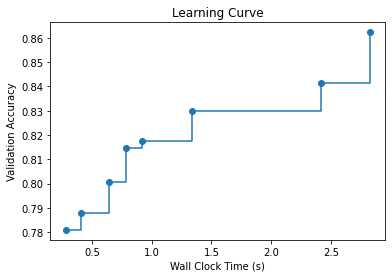

In [10]:
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

feature importance（特徴量重要度）
以下のコードで feature importance（特徴量重要度）を可視化できます。

---



<BarContainer object of 11 artists>

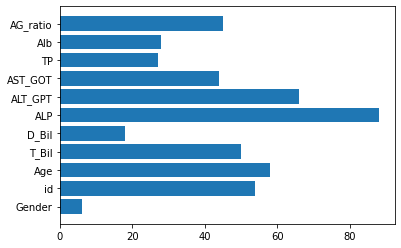

In [12]:
plt.barh(
            automl.model.estimator.feature_name_,
            automl.model.estimator.feature_importances_
         )

In [17]:
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels     ', y_test)
#print(y_test-y_pred) # 真値と予測値の差分

Predicted labels [0 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0
 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0
 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0]
True labels      176    0
762    1
623    0
408    0
685    0
      ..
340    0
51     1
265    1
401    1
180    1
Name: disease, Length: 179, dtype: int64


In [19]:
# 推論
my_pred = automl.predict(test)
print("result：", my_pred)  #  result is 0 or 1

result： [0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1
 1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0
 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0
 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1
 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0
 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0
 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0
 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0
 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0
 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0
 1 1 0 0 0 1 0 0 0 0 0 1]
